In [1]:
#Libraries
using Gen
using PyPlot
using Distributions
using LinearAlgebra
using Flux
using Random
using Distances
using JLD
using StatsBase
include("hmc_mod.jl")
include("helper_functions.jl")
include("rj_proposals_layers.jl")
include("NUTS_CS.jl");

In [103]:
include("rj_proposals_layers.jl")
obs_master = choicemap()::ChoiceMap
obs_master[:y] = y
obs = obs_master;
Random.seed!(2)
(trace,) = generate(interpolator, (x,), obs)
println(trace[(:b,3)])
(new_trace,q) = layer_death(trace)
println(new_trace[(:b,2)])
println(q)

[0.9114098228607301]
[0.9114098228607301]
-20.900283119667353


In [85]:
#---------------------------
#Load Boston Housing Dataset
#---------------------------
data = load("boston.jld")["boston"]

# Generating test/training sets:
nrow, ncol = size(data)
nrow_test  = div(nrow, 3)
nrow_train = nrow - nrow_test

x = data[:,1:13]
y = data[:,14]

dx = fit(UnitRangeTransform, x; dims=1, unit=true)
StatsBase.transform!(dx, x)
dy = fit(UnitRangeTransform, y; dims=1, unit=true)
StatsBase.transform!(dy, y);

x_raw = x
x = transpose(x)

#------------------------------------
#Hyperparameters and Helper Functions
#------------------------------------

#Select Network Goal
#network = "classifier"
network = "interpolator"

#Data hyperparameters
n = nrow #Number of samples per mode (classifier)
d = ncol-1 #Input dimension

#Network hyperparameters
k_real = 5 #Number of hidden nodes per layer
k_vector = [0.0 for i=1:k_real]
k_vector[k_real] = 1.0

#Layer hyperparameters
l_range = 4 #Maximum number of layers in the network
l_list = [Int(i) for i in 1:l_range]
l_real = 1

#NUTS
Δmax = 1000;

In [122]:
#Bayesian Neural Net
function G(x, trace)
    activation = relu
    layers = trace[:l]
    ks = [trace[(:k,i)] for i=1:layers]
    for i=1:layers
        in_dim, out_dim = layer_unpacker(i, layers, ks)
        W = reshape(trace[(:W,i)], out_dim, in_dim)
        b = reshape(trace[(:b,i)], trace[(:k,i)])
        nn = Dense(W, b, activation)
        x = nn(x)
    end
    
    Wₒ = reshape(trace[(:W,layers+1)], 1, ks[layers])
    bₒ = reshape(trace[(:b,layers+1)], 1)
    
    nn_out = Dense(Wₒ, bₒ)
    return nn_out(x)
end;

@gen function interpolator(x)
    
    #Create a blank choicemap
    obs = choicemap()::ChoiceMap
    
    #Draw number of layers
    l ~ categorical([1/length(l_list) for i=1:length(l_list)])
    l_real = l
    obs[:l] = l
    
    #Create individual weight and bias vectors
    #Loop through hidden layers
    k = [Int(0) for i=1:l+1]
    for i=1:l
        k[i] = @trace(categorical(k_vector), (:k,i))
        obs[(:k,i)] = k[i]
    end
    k[l+1] = @trace(categorical([1.0]), (:k,l+1))
    obs[(:k,l+1)] = k[l+1]
    
    ######################################
    #New hyperparameter schedule - Jan 20#
    ######################################
    
    #Standard Deviations
    τ₁ ~ gamma(100,0.001) #Hidden weights and biases
    τ₂ ~ gamma(100*k[1],0.001) #Output weights and biases
    τᵧ ~ gamma(100*k[l], 0.1)
    σ₁ = 1/τ₁
    σ₂ = 1/τ₂
    σᵧ = 1/τᵧ
    
    #Sample weight and bias vectors
    W = [zeros(k[i]) for i=1:l+1]
    b = [zeros(k[i]) for i=1:l+1]
    μ = [zeros(k[i]) for i=1:l+1]
    μb = [zeros(k[i]) for i=1:l+1]

    for i=1:l+1
        if i == 1
            h = Int(d * k[i])
        else
            h = Int(k[i-1] * k[i])
        end

        if i<=l
            #Hidden Weights
            u = zeros(h) #Draw
            S = Diagonal([1 for i=1:length(u)])
            μ[i] = @trace(mvnormal(u,S), (:μ,i))
            Σ = Diagonal([σ₁ for i=1:length(μ[i])])
            W[i] = @trace(mvnormal(μ[i],Σ), (:W,i))
            obs[(:W,i)] = W[i]
            
            #Hidden Biases
            ub = zeros(k[i]) #Draw
            Sb = Diagonal([1 for i=1:length(ub)])    
            μb[i] = @trace(mvnormal(ub,Sb), (:μb,i))
            Σ2 = Diagonal([σ₁ for i=1:length(μb[i])])
            b[i] = @trace(mvnormal(μb[i],Σ2), (:b,i))
            obs[(:b,i)] = b[i]
        else
            #Output Weights
            u = zeros(k[l]) #Draw
            S = Diagonal([1 for i=1:length(u)])
            μ[i] = @trace(mvnormal(u,S), (:μ,i))
            Σ = Diagonal([σ₂ for i=1:length(μ[i])])
            W[i] = @trace(mvnormal(μ[i],Σ), (:W,i))
            obs[(:W,i)] = W[i]

            #Output Bias
            ub = zeros(1) #Draw
            Sb = Diagonal([1 for i=1:length(ub)])  
            μb[i] = @trace(mvnormal(ub,Sb), (:μb,i))
            Σ2 = Diagonal([σ₂ for i=1:length(μb[i])])
            b[i] = @trace(mvnormal(μb[i],Σ2), (:b,i))
            obs[(:b,i)] = b[i]
        end
    end
    
    #Return Network Scores for X
    scores = G(x,obs)
    scores = Flux.σ.(scores)
    
    #Regression Likelihood
    y = @trace(mvnormal(vec(scores), Diagonal([σᵧ for i=1:length(x[1,:])])), (:y))

    return scores
    
end;

#Register Observed Data - Bernoulli
obs_master = choicemap()::ChoiceMap
obs_master[:y] = y
obs = obs_master;

(best_trace,) = generate(interpolator, (x,), obs)
#println(best_trace[:τ₁])
#println(best_trace[:τ₂])
println(best_trace[:τᵧ])

test_scores = interpolator(x);

52.231725697585766


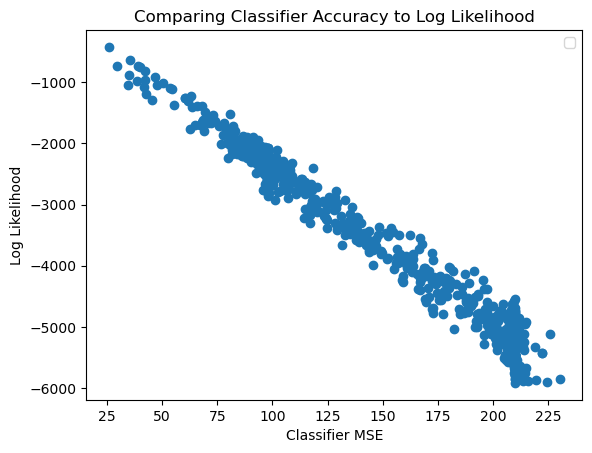

No handles with labels found to put in legend.


PyObject <matplotlib.legend.Legend object at 0x7f9f5c32d050>

In [123]:
#----------------
#Test Likelihood
#----------------
scores = []
mses = []
ks = []
best_traces = []
(best_trace,) = generate(interpolator, (x,), obs)
best_score = get_score(best_trace)
best_pred_y = Flux.σ.(G(x, best_trace))
best_mse = mse_regression(best_pred_y, y)

function likelihood(best_trace, best_mse, best_score)
    obs = obs_master;
    (trace,) = generate(interpolator, (x,), obs)
    
    pred_y = Flux.σ.(G(x, trace))
    mse = mse_regression(pred_y, y)
    score = get_score(trace)
    
    if mse < best_mse
        best_mse = mse
        best_score = score
        best_trace = trace
        best_pred_y = pred_y
    end
    push!(scores,score)
    push!(mses,mse)
    return(best_trace, best_mse, best_score)
end;

for i=1:1000
    best_trace, best_mse, best_score = likelihood(best_trace, best_mse, best_score)
end

PyPlot.scatter(mses, scores)
plt.title("Comparing Classifier Accuracy to Log Likelihood")
plt.xlabel("Classifier MSE")
plt.ylabel("Log Likelihood")
#plt.ylim(-10000,1)
plt.legend()

In [125]:
###############
#NUTS SAMPLING#
###############

include("NUTS_CS.jl")
Δ_max = 1000
Random.seed!(4)

scores = []
traces = []
ks = []
across_acceptance = []
within_acceptance = []
hyper1_acceptance = []
hyper2_acceptance = []

#HMC Hyperparameters
iters = 1

function propose_hyperparameters(trace)
    
    hyper_selection = select()
    push!(hyper_selection, :τ₁)
    push!(hyper_selection, :τ₂)
    push!(hyper_selection, :τᵧ)
    (new_trace, weight, retdiff) = regenerate(trace, hyper_selection)
    
    if log(rand()) < weight
        return (new_trace, 1)
    else
        return (trace, 0)
    end
end;

function hmc_parameters(trace)
    
    param_selection = select()
    for i=1:1+1 #Number of Layers
        push!(param_selection, (:W,i))
        push!(param_selection, (:b,i))
    end
    
    prev_score = get_score(trace)
    
    acc = 0
    for i=1:iters
        trace = NUTS(trace, param_selection, 0.65, 3, 3, false)[4]
        new_score = get_score(trace)
        if prev_score != new_score
            acc = 1
        end
    end
    
    return (trace, acc)
end

function hmc_hyperparameters2(trace)
    
    hyper2_selection = select()
    for i=1:1+1 #Number of Layers
        push!(hyper2_selection, (:μ,i))
        push!(hyper2_selection, (:μb,i))
    end
    
    prev_score = get_score(trace)
    #trace = NUTS(trace, hyper2_selection, 0.65, 3, 3, false)[4]
    #new_score = get_score(trace)
    
    (new_trace, weight, retdiff) = regenerate(trace, hyper2_selection)
    
    if log(rand()) < weight
        return (new_trace, 1)
    else
        return (trace, 0)
    end
    
    #if prev_score != new_score
        #return (trace, 1)
    #else
        #return (trace, 0)
    #end
    
end

function node_parameter(trace)
    obs = obs_master
    
    init_trace = trace
    
    #################################################RJHMC#################################################
    #HMC Step 1
    trace_tilde = trace
    for i=1:iters
        (trace_tilde,) = propose_hyperparameters(trace_tilde)
        (trace_tilde,) = hmc_hyperparameters2(trace_tilde)
        (trace_tilde,) = hmc_parameters(trace_tilde)
        #(trace_tilde, accepted) = hmc(trace_tilde,param_selection,L=leap,eps=ϵ,check=false,observations=obs)
    end
    #Reversible Jump Step
    (trace_prime, q_weight) = layer_change(trace_tilde)
    #HMC Step 2
    trace_star = trace_prime
    for i=1:iters
        #(trace_star, accepted) = hmc(trace_star,param_selection,L=leap,eps=ϵ,check=false,observations=obs)
        (trace_star,) = hmc_parameters(trace_star)
        (trace_star,) = hmc_hyperparameters2(trace_star)
        (trace_star,) = propose_hyperparameters(trace_star) 
    end
    #################################################RJHMC#################################################
        
    model_score = -get_score(init_trace) + get_score(trace_star)
    across_score = model_score + q_weight
    #println(across_score)
    #println(model_score)

    if rand() < exp(across_score)
        println("********** Accepted: $(trace_star[:l]) **********")
        return (trace_star, 1)
    else
        return (init_trace, 0)
    end
end

(trace,) = generate(interpolator, (x,), obs)
#trace = best_trace

for i=1:50
    (trace, accepted) = node_parameter(trace)
    push!(across_acceptance, accepted)
    (trace, accepted)  = propose_hyperparameters(trace)
    push!(hyper1_acceptance, accepted)
    (trace, accepted)  = hmc_hyperparameters2(trace)
    push!(hyper2_acceptance, accepted)
    (trace, accepted)  = hmc_parameters(trace)
    push!(within_acceptance, accepted)
    push!(scores,get_score(trace))
    push!(traces, trace)
    push!(ks, trace[(:k,1)])
    println("$i : $(get_score(trace))")
    if i%20 == 0
        a_acc = 100*(sum(across_acceptance)/length(across_acceptance))
        w_acc = 100*(sum(within_acceptance)/length(within_acceptance))
        println("Epoch $i A Acceptance Probability: $a_acc %")
        println("Epoch $i W Acceptance Probability: $w_acc %")
    end
end

1 : -2570.9697192127924
2 : -2429.541414828567
3 : -2429.541414828567
********** Accepted: 4 **********
4 : -984.1206850481467
5 : -988.0031712447476
6 : -995.3758945436344
7 : -987.5199891028376
8 : -1636.7004949508853
9 : -1636.7004949508853
10 : -1636.7004949508853
11 : -1523.4113200113875
12 : -1634.7325298049743
13 : -1174.5248502262857
14 : -1447.23166097706
15 : -1483.2484314807232
16 : -1256.4152967436241
17 : -1041.8577301191426
18 : -924.2166627405627
19 : -969.1834985926159
20 : -967.3518427245965
Epoch 20 A Acceptance Probability: 5.0 %
Epoch 20 W Acceptance Probability: 75.0 %
21 : -1035.3229708839056
22 : -1170.7881161650637
23 : -1605.887170591221
24 : -1034.9185146939803
25 : -1319.292385736027
26 : -958.6787645353245
27 : -963.4457986525247
28 : -992.8060138820883
29 : -1198.2305332991673
30 : -1575.4519523931313
31 : -926.128131410288
32 : -1144.5738096495822
33 : -1164.5821925175296


InterruptException: InterruptException:

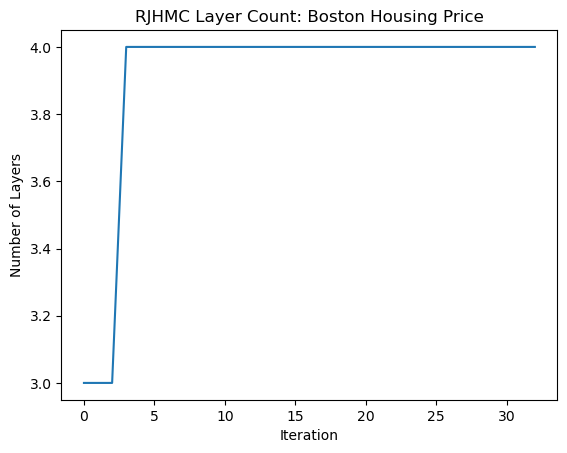

In [126]:
#Layers Plot
layers = [trace[:l] for trace in traces]
plot(layers)
plt.title("RJHMC Layer Count: Boston Housing Price")
plt.xlabel("Iteration")
plt.ylabel("Number of Layers");

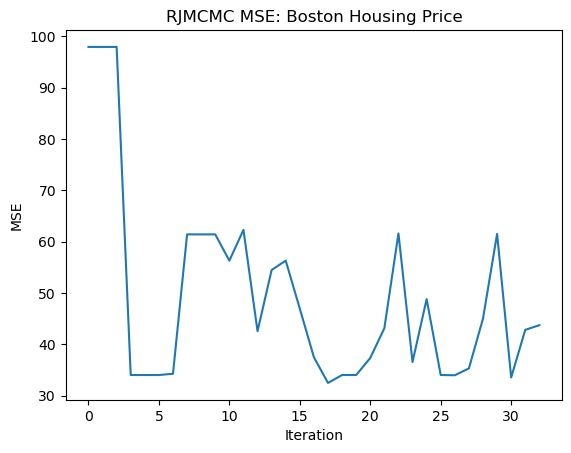

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.5495211189380276, 0.5495211189380276, 0.5495211189380276, 0.5495211189380276, 0.5495211189380276, 0.5495211189380276]
[0.5495211189380276, 0.5495211189380276, 0.5495211189380276, 0.5495211189380276, 0.5495211189380276, 0.5495211189380276]
[0.5495211189380276, 0.5495211189380276, 0.5495211189380276, 0.5495211189380276, 0.5495211189380276, 0.5495211189380276]
[0.5495211189380276, 0.5495211189380276, 0.5495211189380276, 0.5495211189380276, 0.5495211189380276, 0.5495211189380276]
[0.5495211189380276, 0.5495211189380276, 0.5495211189380276, 0.5495211189380276, 0.5495211189380276, 0.5495211189380276]
[0.5495211189380276, 0.5495211189380276, 0.5495211189380276, 0.5495211189380276, 0.5495211189380276, 0.5495211189380276]
[0.5495211189380276, 0.5495211189380276, 0.5495211189380276, 0.5495211189380276, 0.5495211189380276, 0.5495211189380276]
[0.5495211189380276, 0.5495211189380276, 0.5495211189380276,

In [129]:
#Plot MSE Scores by Trace
mses = []
for i=1:length(traces)
    trace = traces[i]
    pred_y = Flux.σ.(G(x,trace))
    mse = mse_regression(pred_y, y)
    println(pred_y[10:15])

    push!(mses,mse)
end

plot(mses)
plt.title("RJMCMC MSE: Boston Housing Price")
plt.xlabel("Iteration")
plt.ylabel("MSE");

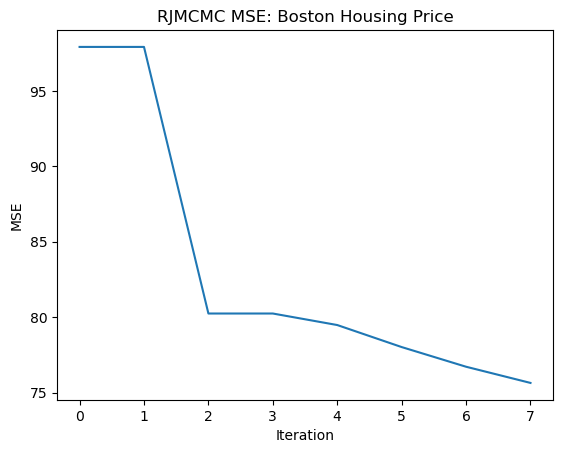

In [63]:
#Plot MSE Scores by Trace
mses = []
for i=1:length(traces)
    trace = traces[i]
    pred_y = Flux.σ.(G(x,trace))
    mse = mse_regression(pred_y, y)

    push!(mses,mse)
end

plot(mses)
plt.title("RJMCMC MSE: Boston Housing Price")
plt.xlabel("Iteration")
plt.ylabel("MSE");

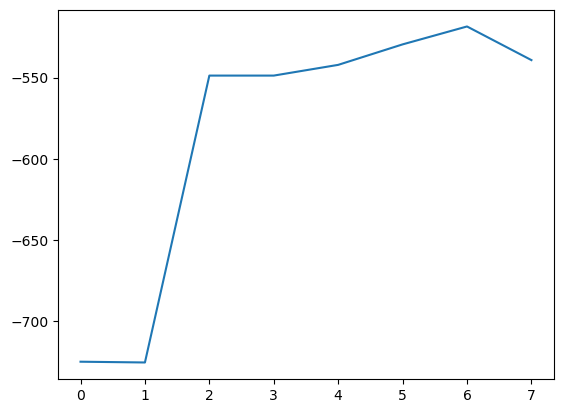

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f9f4dca0e90>

In [64]:
scores = [get_score(trace) for trace in traces]
plot(scores)

In [ ]:
#--------------------
#RJMCMC - using HMC
#--------------------
traces = []
scores = []
acc = []
acc_l = []
acc_w = []
l_results = []
epss = []
l = 10
ϵ = 0.001

function within_move(trace, iters, obs, prev_trace)
    selection = select_selection(trace)
    score1 = get_score(prev_trace)
    (new_trace, hmc_score) = hmc_mod(trace, selection, L=l, eps=ϵ, check=false, observations=obs)
    
    score2 = get_score(new_trace)
    #println("new trace score: $score2")
    #println("old trace score: $score1")
    acc_score = score2 - score1
    #println("Calc score: $acc_score")
    #println("hmc_score: $hmc_score")
    if rand(Uniform(0,1)) < exp(hmc_score)
        trace = new_trace
        accepted = 1.0
        #println("Accepted")
    else
        trace = prev_trace
        accepted = 0.0
        #println("Not Accepted")
    end
    #push!(traces, trace)
    push!(acc, accepted)
    push!(acc_w, accepted)
    #accepted && println("Within accepted")
    return trace
end

function rjmcmc(starting_trace, iters)
    trace = starting_trace
    l = trace[:l]
    ks = [trace[(:k,i)] for i=1:trace[:l]]
    println("Beginning RJMCMC")
    println("Starting ks: $ks")
    println("--------------------------------")

    for i=1:iters
        l = trace[:l]
        obs = obs_master;
        if i%50 == 0
            #println("Epoch $i Acceptance Prob: $(sum(acc)/length(acc))")
            #println("Epoch $i layer count: $l, ks: $ks")
            println("Epoch $i Within Acceptance Prob: $(sum(acc_w)/length(acc_w))")
            #println("Epoch $i Layer Acceptance Prob: $(sum(acc_l)/length(acc_l))")
            #println([trace[(:k,i)] for i=1:trace[:l]])
        end
        
        #Gibbs sampling for hyperparameters
        prev_trace = trace
        trace, obs = select_hyperparameters(prev_trace, obs)
        
        #Indicator variable for move type
        u = rand(Uniform(0,1))
        if u > 1.0
            (trace) = layer_move(trace, 3, obs, prev_trace)
        else
            (trace) = within_move(trace, 10, obs, prev_trace)
        end
        push!(traces, trace)
        push!(scores, get_score(trace))
        push!(l_results, trace[:l])
    end
    println("Finished")
end
 
runs = 2000

obs_master = choicemap()::ChoiceMap
obs_master[:y] = y
obs_master[:l] = 4
obs = obs_master;
(starting_trace,) = generate(interpolator, (x,), obs)
#starting_trace = best_trace

include("NUTS.jl");
rjmcmc(starting_trace,runs);